In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import Lasso

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#loading data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## Data Pre-Processing

In [3]:
# removing outliers
train.drop(train[train['GrLivArea'] > 4000].index, inplace=True)
train.shape # removed 4 rows`

(1456, 81)

In [4]:
# imputing using mode
test.loc[666, 'GarageQual'] = "TA" #stats.mode(test['GarageQual']).mode
test.loc[666, 'GarageCond'] = "TA" #stats.mode(test['GarageCond']).mode
test.loc[666, 'GarageFinish'] = "Unf" #stats.mode(test['GarageFinish']).mode
test.loc[666, 'GarageYrBlt'] = "1980" #np.nanmedian(test['GarageYrBlt'])

In [5]:
# mark as missing
test.loc[1116, 'GarageType'] = np.nan

In [6]:
#importing function
le = LabelEncoder()
def factorize(data, var, fill_na=None):
    if fill_na is not None:
        data[var].fillna(fill_na, inplace=True)
    le.fit(data[var])
    data[var] = le.transform(data[var])
    return data

In [7]:
# combine the data set
alldata = train.append(test)
alldata.shape

(2915, 81)

In [8]:
# impute lotfrontage by median of neighborhood
lot_frontage_by_neighborhood = train['LotFrontage'].groupby(train['Neighborhood'])

for key, group in lot_frontage_by_neighborhood:
    idx = (alldata['Neighborhood'] == key) & (alldata['LotFrontage'].isnull())
    alldata.loc[idx, 'LotFrontage'] = group.median()

In [9]:
# imputing missing values
alldata["MasVnrArea"].fillna(0, inplace=True)
alldata["BsmtFinSF1"].fillna(0, inplace=True)
alldata["BsmtFinSF2"].fillna(0, inplace=True)
alldata["BsmtUnfSF"].fillna(0, inplace=True)
alldata["TotalBsmtSF"].fillna(0, inplace=True)
alldata["GarageArea"].fillna(0, inplace=True)
alldata["BsmtFullBath"].fillna(0, inplace=True)
alldata["BsmtHalfBath"].fillna(0, inplace=True)
alldata["GarageCars"].fillna(0, inplace=True)
alldata["GarageYrBlt"].fillna(0.0, inplace=True)
alldata["PoolArea"].fillna(0, inplace=True)

In [10]:
# convert the categorical variables into ordinal variables
qual_dict = {np.nan: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
name = np.array(['ExterQual', 'PoolQC', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond'])

for i in name:
     alldata[i] = alldata[i].map(qual_dict).astype(int)

alldata["BsmtExposure"] = alldata["BsmtExposure"].map({np.nan: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

bsmt_fin_dict = {np.nan: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
alldata["BsmtFinType1"] = alldata["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
alldata["BsmtFinType2"] = alldata["BsmtFinType2"].map(bsmt_fin_dict).astype(int)
alldata["Functional"] = alldata["Functional"].map({np.nan: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
                                                   "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

alldata["GarageFinish"] = alldata["GarageFinish"].map({np.nan: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)
alldata["Fence"] = alldata["Fence"].map({np.nan: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

#encoding data
alldata["CentralAir"] = (alldata["CentralAir"] == "Y") * 1.0
varst = np.array(['MSSubClass', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 
                  'HouseStyle', 'RoofStyle', 'Foundation', 'SaleCondition'])

for x in varst:
         factorize(alldata, x)

# encode variables and impute missing values
alldata = factorize(alldata, "MSZoning", "RL")
alldata = factorize(alldata, "Exterior1st", "Other")
alldata = factorize(alldata, "Exterior2nd", "Other")
alldata = factorize(alldata, "MasVnrType", "None")
alldata = factorize(alldata, "SaleType", "Oth")

## Feature Engineering

In [11]:
# creating new variable (1 or 0) based on irregular count levels
# The level with highest count is kept as 1 and rest as 0
alldata["IsRegularLotShape"] = (alldata["LotShape"] == "Reg") * 1
alldata["IsLandLevel"] = (alldata["LandContour"] == "Lvl") * 1
alldata["IsLandSlopeGentle"] = (alldata["LandSlope"] == "Gtl") * 1
alldata["IsElectricalSBrkr"] = (alldata["Electrical"] == "SBrkr") * 1
alldata["IsGarageDetached"] = (alldata["GarageType"] == "Detchd") * 1
alldata["IsPavedDrive"] = (alldata["PavedDrive"] == "Y") * 1
alldata["HasShed"] = (alldata["MiscFeature"] == "Shed") * 1
alldata["Remodeled"] = (alldata["YearRemodAdd"] != alldata["YearBuilt"]) * 1

# Did the modeling happen during the sale year?
alldata["RecentRemodel"] = (alldata["YearRemodAdd"] == alldata["YrSold"]) * 1

# Was this house sold in the year it was built?
alldata["VeryNewHouse"] = (alldata["YearBuilt"] == alldata["YrSold"]) * 1
alldata["Has2ndFloor"] = (alldata["2ndFlrSF"] == 0) * 1
alldata["HasMasVnr"] = (alldata["MasVnrArea"] == 0) * 1
alldata["HasWoodDeck"] = (alldata["WoodDeckSF"] == 0) * 1
alldata["HasOpenPorch"] = (alldata["OpenPorchSF"] == 0) * 1
alldata["HasEnclosedPorch"] = (alldata["EnclosedPorch"] == 0) * 1
alldata["Has3SsnPorch"] = (alldata["3SsnPorch"] == 0) * 1
alldata["HasScreenPorch"] = (alldata["ScreenPorch"] == 0) * 1

# setting levels with high count as 1 and the rest as 0
# you can check for them using the value_counts function
alldata["HighSeason"] = alldata["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 
                                                   7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
alldata["NewerDwelling"] = alldata["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0, 50: 0, 60: 1, 
                                                          70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 120: 1, 
                                                          150: 0, 160: 0, 180: 0, 190: 0})

In [12]:
alldata.shape

(2915, 100)

In [13]:
# create alldata2
alldata2 = train.append(test)

alldata["SaleCondition_PriceDown"] = alldata2.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 
                                                                     'AdjLand': 1, 'Family': 1, 
                                                                     'Normal': 0, 'Partial': 0})

# house completed before sale or not
alldata["BoughtOffPlan"] = alldata2.SaleCondition.replace({"Abnorml": 0, "Alloca": 0, "AdjLand": 0, 
                                                           "Family": 0, "Normal": 0, "Partial": 1})
alldata["BadHeating"] = alldata2.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

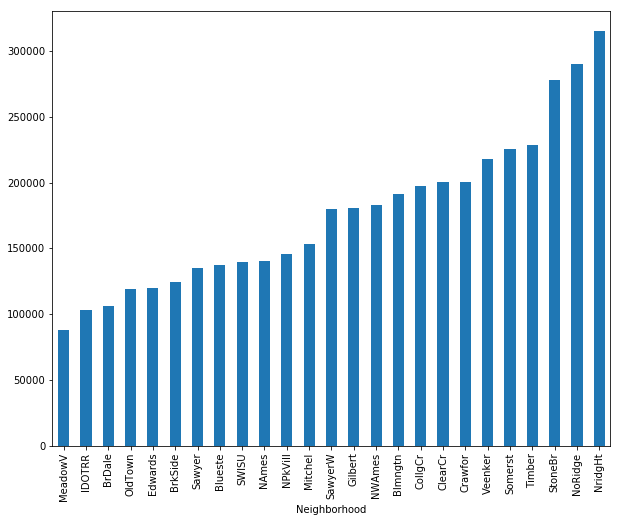

In [14]:
# calculating total area using all area columns
area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
             'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 
             'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
             '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]

alldata["TotalArea"] = alldata[area_cols].sum(axis=1)
alldata["TotalArea1st2nd"] = alldata["1stFlrSF"] + alldata["2ndFlrSF"]
alldata["Age"] = 2010 - alldata["YearBuilt"]
alldata["TimeSinceSold"] = 2010 - alldata["YrSold"]
alldata["SeasonSold"] = alldata["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 
                                               7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
alldata["YearsSinceRemodel"] = alldata["YrSold"] - alldata["YearRemodAdd"]

# Simplifications of existing features into bad/average/good based on counts
alldata["SimplOverallQual"] = alldata.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 
                                                           6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplOverallCond"] = alldata.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 
                                                           6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplPoolQC"] = alldata.PoolQC.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2})
alldata["SimplGarageCond"] = alldata.GarageCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplGarageQual"] = alldata.GarageQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFunctional"] = alldata.Functional.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 
                                                         6 : 3, 7 : 3, 8 : 4})
alldata["SimplKitchenQual"] = alldata.KitchenQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplHeatingQC"] = alldata.HeatingQC.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplBsmtFinType1"] = alldata.BsmtFinType1.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
alldata["SimplBsmtFinType2"] = alldata.BsmtFinType2.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
alldata["SimplBsmtCond"] = alldata.BsmtCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplBsmtQual"] = alldata.BsmtQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplExterCond"] = alldata.ExterCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplExterQual"] = alldata.ExterQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

#grouping neighborhood variable based on this plot
train['SalePrice'].groupby(train['Neighborhood']).median().sort_values().plot(kind='bar')
plt.show()

In [15]:
neighborhood_map = {"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, 
                    "BrkSide" : 1, "Sawyer" : 1, "Blueste" : 1, "SWISU" : 2, "NAmes" : 2, 
                    "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2, "NWAmes" : 2, 
                    "Blmngtn" : 2, "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3, 
                    "Somerst" : 3, "Timber" : 3, "StoneBr" : 4, "NoRidge" : 4, "NridgHt" : 4}

alldata['NeighborhoodBin'] = alldata2['Neighborhood'].map(neighborhood_map)
alldata.loc[alldata2.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
alldata["Neighborhood_Good"].fillna(0, inplace=True)
alldata["SaleCondition_PriceDown"] = alldata2.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 
                                                                     'AdjLand': 1, 'Family': 1, 
                                                                     'Normal': 0, 'Partial': 0})

# House completed before sale or not
alldata["BoughtOffPlan"] = alldata2.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                           "Family" : 0, "Normal" : 0, "Partial" : 1})
alldata["BadHeating"] = alldata2.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})
alldata.shape

(2915, 126)

In [16]:
#create new data
train_new = alldata[alldata['SalePrice'].notnull()]
test_new = alldata[alldata['SalePrice'].isnull()]

print('Train', train_new.shape)
print('-------------------')
print('Test', test_new.shape)

Train (1456, 126)
-------------------
Test (1459, 126)


In [17]:
#get numeric features
numeric_features = [f for f in train_new.columns if train_new[f].dtype != object]

#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = train_new[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
train_new[skewed] = np.log1p(train_new[skewed])
test_new[skewed] = np.log1p(test_new[skewed])
del test_new['SalePrice']

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [18]:
scaler = StandardScaler()
scaler.fit(train_new[numeric_features])
scaled = scaler.transform(train_new[numeric_features])

for i, col in enumerate(numeric_features):
    train_new[col] = scaled[:,i]

numeric_features.remove('SalePrice')
scaled = scaler.fit_transform(test_new[numeric_features])

for i, col in enumerate(numeric_features):
    test_new[col] = scaled[:,i]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
def onehot(onehot_df, df, column_name, fill_na):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(onehot_df[column_name], prefix="_"+column_name)
    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df

def munge_onehot(df):
    onehot_df = pd.DataFrame(index = df.index)

    onehot_df = onehot(onehot_df, df, "MSSubClass", None)
    onehot_df = onehot(onehot_df, df, "MSZoning", "RL")
    onehot_df = onehot(onehot_df, df, "LotConfig", None)
    onehot_df = onehot(onehot_df, df, "Neighborhood", None)
    onehot_df = onehot(onehot_df, df, "Condition1", None)
    onehot_df = onehot(onehot_df, df, "BldgType", None)
    onehot_df = onehot(onehot_df, df, "HouseStyle", None)
    onehot_df = onehot(onehot_df, df, "RoofStyle", None)
    onehot_df = onehot(onehot_df, df, "Exterior1st", "VinylSd")
    onehot_df = onehot(onehot_df, df, "Exterior2nd", "VinylSd")
    onehot_df = onehot(onehot_df, df, "Foundation", None)
    onehot_df = onehot(onehot_df, df, "SaleType", "WD")
    onehot_df = onehot(onehot_df, df, "SaleCondition", "Normal")

    # Fill in missing MasVnrType for rows that do have a MasVnrArea.
    temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
    idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
    temp_df.loc[idx, "MasVnrType"] = "BrkFace"
    onehot_df = onehot(onehot_df, temp_df, "MasVnrType", None)

    onehot_df = onehot(onehot_df, df, "LotShape", None)
    onehot_df = onehot(onehot_df, df, "LandContour", None)
    onehot_df = onehot(onehot_df, df, "LandSlope", None)
    onehot_df = onehot(onehot_df, df, "Electrical", "SBrkr")
    onehot_df = onehot(onehot_df, df, "GarageType", None)
    onehot_df = onehot(onehot_df, df, "PavedDrive", None)
    onehot_df = onehot(onehot_df, df, "MiscFeature", None)
    onehot_df = onehot(onehot_df, df, "Street", None)
    onehot_df = onehot(onehot_df, df, "Alley", None)
    onehot_df = onehot(onehot_df, df, "Condition2", None)
    onehot_df = onehot(onehot_df, df, "RoofMatl", None)
    onehot_df = onehot(onehot_df, df, "Heating", None)

    # we'll have these as numerical variables too
    onehot_df = onehot(onehot_df, df, "ExterQual", None)
    onehot_df = onehot(onehot_df, df, "ExterCond", None)
    onehot_df = onehot(onehot_df, df, "BsmtQual", None)
    onehot_df = onehot(onehot_df, df, "BsmtCond", None)
    onehot_df = onehot(onehot_df, df, "HeatingQC", None)
    onehot_df = onehot(onehot_df, df, "KitchenQual", "TA")
    onehot_df = onehot(onehot_df, df, "FireplaceQu", None)
    onehot_df = onehot(onehot_df, df, "GarageQual", None)
    onehot_df = onehot(onehot_df, df, "GarageCond", None)
    onehot_df = onehot(onehot_df, df, "PoolQC", None)
    onehot_df = onehot(onehot_df, df, "BsmtExposure", None)
    onehot_df = onehot(onehot_df, df, "BsmtFinType1", None)
    onehot_df = onehot(onehot_df, df, "BsmtFinType2", None)
    onehot_df = onehot(onehot_df, df, "Functional", "Typ")
    onehot_df = onehot(onehot_df, df, "GarageFinish", None)
    onehot_df = onehot(onehot_df, df, "Fence", None)
    onehot_df = onehot(onehot_df, df, "MoSold", None)

    # Divide  the years between 1871 and 2010 into slices of 20 years
    year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20))  for i in range(0, 7))
    yearbin_df = pd.DataFrame(index = df.index)
    yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
    yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)
    yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
    yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)

    onehot_df = onehot(onehot_df, yearbin_df, "GarageYrBltBin", None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearBuiltBin", None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearRemodAddBin", None)
    return onehot_df

# create one-hot features
onehot_df = munge_onehot(train)

neighborhood_train = pd.DataFrame(index=train_new.shape)
neighborhood_train['NeighborhoodBin'] = train_new['NeighborhoodBin']
neighborhood_test = pd.DataFrame(index=test_new.shape)
neighborhood_test['NeighborhoodBin'] = test_new['NeighborhoodBin']

onehot_df = onehot(onehot_df, neighborhood_train, 'NeighborhoodBin', None)

In [20]:
train_new = train_new.join(onehot_df) 
train_new.shape

(1456, 419)

In [21]:
# adding one hot features to test
onehot_df_te = munge_onehot(test)
onehot_df_te = onehot(onehot_df_te, neighborhood_test, "NeighborhoodBin", None)
test_new = test_new.join(onehot_df_te)
test_new.shape

(1459, 403)

In [22]:
#dropping some columns from the train data as they are not found in test
drop_cols = ["_Exterior1st_ImStucc", "_Exterior1st_Stone", "_Exterior2nd_Other", 
             "_HouseStyle_2.5Fin","_RoofMatl_Membran", "_RoofMatl_Metal", 
             "_RoofMatl_Roll", "_Condition2_RRAe", "_Condition2_RRAn", 
             "_Condition2_RRNn", "_Heating_Floor", "_Heating_OthW", 
             "_Electrical_Mix", "_MiscFeature_TenC", "_GarageQual_Ex", "_PoolQC_Fa"]
train_new.drop(drop_cols, axis=1, inplace=True)
train_new.shape

(1456, 403)

In [23]:
# removing one column missing from train data
test_new.drop(["_MSSubClass_150"], axis=1, inplace=True)

# Drop these columns
drop_cols = ["_Condition2_PosN", # only two are not zero
         "_MSZoning_C (all)",
         "_MSSubClass_160"]

train_new.drop(drop_cols, axis=1, inplace=True)
test_new.drop(drop_cols, axis=1, inplace=True)

In [24]:
# create a label set
label_df = pd.DataFrame(index = train_new.index, columns = ['SalePrice'])
label_df['SalePrice'] = np.log(train['SalePrice'])
print("Training set size:", train_new.shape)
print("Test set size:", test_new.shape)

Training set size: (1456, 400)
Test set size: (1459, 399)


## Model Training and Evaluation

In [27]:
# XGBoost model
regr = xgb.XGBRegressor(colsample_bytree=0.2,
                        gamma=0.0,
                        learning_rate=0.05,
                        max_depth=6,
                        min_child_weight=1.5,
                        n_estimators=7200,
                        reg_alpha=0.9,
                        reg_lambda=0.6,
                        subsample=0.2,
                        seed=42,
                        silent=1)

regr.fit(train_new, label_df)